In [5]:
import os
from datetime import datetime
from typing import Dict, Tuple, Any
from tqdm import tqdm
import pickle

import math
import numpy as np
import pandas as pd

import cv2
import albumentations
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

import timm

In [3]:
# ---------------------------------------
# parameters

MODEL_DIR = './model_checkpoints/'
DATA_DIR = '../input/'
LOG_DIR = './logs/'
DEVICE = 'cuda:0'
MODEL_NAME = 'rexnet_200'

TRAIN_STEP = 0
FOLD = 0

IMAGE_SIZE = 256
BATCH_SIZE = 64
NUM_EPOCHS = 10
NUM_WORKERS = 4
LR = 1e-4
USE_AMP = True


In [12]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

In [11]:
dffull = pd.read_csv(os.path.join(DATA_DIR, 'train_full.csv'))

In [31]:
landmark_set = set(df['landmark_id'].unique())

In [30]:
dffull.loc[dffull['id'] == 'fb09f1e98c6d2f70', 'url'].tolist()

['http://upload.wikimedia.org/wikipedia/commons/3/3c/Luitpoldpark_Muenchen-11.jpg']

In [34]:
dffull['filtered_landmark'] = dffull['landmark_id'].apply(lambda x: x in landmark_set)

In [39]:
np.save("./embeddings/trainfull_embedding_filter", dffull.loc[dffull['filtered_landmark'] == True].index.values)

In [40]:
train_embedding = np.load('./embeddings/effnetb3_600_fold1_epoch5_trainfull_embeddings.npy')

In [42]:
trainfull_filter = dffull.loc[dffull['filtered_landmark'] == True].index.values

In [44]:
dffull.head()

,id,url,landmark_id,filtered_landmark
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,True
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,True
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,True
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,True
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,True


In [54]:
dffull_filtered = dffull.loc[dffull['filtered_landmark'] == True, 'landmark_id']

In [64]:
np.save('./embeddings/trainfullfiltered_embeddings_targets', dffull_filtered.values)

In [43]:
trainfull_filter

array([      0,       1,       2, ..., 4132911, 4132912, 4132913])

In [46]:
train_embedding = train_embedding[trainfull_filter]

In [52]:
train_embedding.shape

(3223078, 512)

In [49]:
np.save('./embeddings/effnetb3_600_fold1_epoch5_trainfullfiltered_embeddings', train_embedding)

In [24]:
df['old_filepath'] = df['id'].apply(lambda x: os.path.join(DATA_DIR, 'train', x[0], x[1], x[2], f'{x}.jpg'))

In [5]:
df['new_filepath'] = df['id'].apply(lambda x: os.path.join(DATA_DIR, 'gldv2_full', x[0], x[1], x[2], f'{x}.jpg'))

In [6]:
df.head()

,id,landmark_id,old_filepath,new_filepath
0,17660ef415d37059,1,../input/train/1/7/6/17660ef415d37059.jpg,../input/gldv2_full/1/7/6/17660ef415d37059.jpg
1,92b6290d571448f6,1,../input/train/9/2/b/92b6290d571448f6.jpg,../input/gldv2_full/9/2/b/92b6290d571448f6.jpg
2,cd41bf948edc0340,1,../input/train/c/d/4/cd41bf948edc0340.jpg,../input/gldv2_full/c/d/4/cd41bf948edc0340.jpg
3,fb09f1e98c6d2f70,1,../input/train/f/b/0/fb09f1e98c6d2f70.jpg,../input/gldv2_full/f/b/0/fb09f1e98c6d2f70.jpg
4,25c9dfc7ea69838d,7,../input/train/2/5/c/25c9dfc7ea69838d.jpg,../input/gldv2_full/2/5/c/25c9dfc7ea69838d.jpg


In [9]:
import matplotlib.pyplot as plt

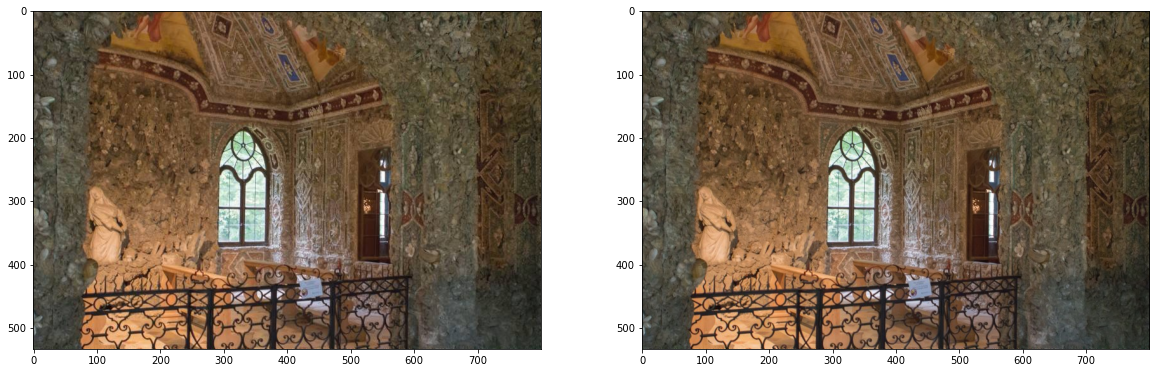

In [24]:
idx = 198412
img0 = cv2.imread(df['old_filepath'].iloc[idx])
img1 = cv2.imread(df['new_filepath'].iloc[idx])

_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img0[:, :, ::-1])
ax[1].imshow(img1[:, :, ::-1])

In [27]:
for i in tqdm(range(df.shape[0])):
    assert os.path.exists(df['new_filepath'].iloc[i])

100%|██████████| 1580470/1580470 [00:22<00:00, 70717.52it/s] 
